## Trabalho final de Data Processing With Python 

• O departamento de crédito da QuantumFinance solicitou a criação de um algoritmo para prever o preço de venda de suas casas com base em várias características. Eles coletaram dados de vendas recentes, incluindo informações como o tamanho da casa (em pés quadrados), o número de quartos, o número de banheiros, a idade da casa (em anos) e a proximidade com o centro da cidade (em quilômetros).

• O objetivo é desenvolver um modelo de Regressão Linear Multivariada que preveja o preço de venda das casas com base nessas características. Para isso, você recebeu um conjunto de dados contendo informações de venda de várias casas, incluindo o preço de venda e as características mencionadas anteriormente.

### Download e tratamento dos dados

#### Analisando qualidade dos dados

_Importando dependências_

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import numpy as np

from scipy import stats 

_Exploratory Data Analysis (EDA)_

In [2]:
df = pd.read_csv('house_prices.csv',sep=',')

In [3]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

#### Feature Engineering

Analisando uma amostra da base

In [5]:
pd.set_option('display.max_columns', 500)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Função para remoção de Outliers

In [6]:
def outliers(df, columns, z_threshold=3):
    """
    Remoção de outliers de uma coluna específica no dataframe utilizando o método Z-score.
    Z-score é o o cálculo estatístico que descreve a quantidade de desvios padrões que o valor se distancia da média.

    Z = (X-mean)/desv
    
    """
    df_c = df.copy()

    df_c['outlier'] = 0

    for c in columns:
        # Cálculo do z-score
        z_scores = stats.zscore(df_c[c])
        
        # Identifica outliers
        abs_z_scores = abs(z_scores)
        filtered_entries = (abs_z_scores > z_threshold).astype(int)

        # print(f"{c}:{filtered_entries}")

        df_c['outlier'] = df_c['outlier']+filtered_entries
    
    df_c['outlier'].loc[df_c['outlier']>0] = 1

    return df_c

In [7]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [9]:
columns_to_check = df.drop(columns=['id','date','zipcode','yr_built', 'yr_renovated','lat','long','sqft_living15', 'sqft_lot15'])

dfr = outliers(df,columns_to_check)

dfr[['outlier','id']].groupby('outlier',as_index=False).count()


# """
# Tenho apenas 1804 linhas com outliers para as variáveis selecionadas, o que representa 3.7% do total de linhas.
# Os outliers portanto serão removidos. 
# """

,outlier,id
0,0,19809
1,1,1804


Seleção apenas de elementos que não sejam outliers para criação de um novo outlier

In [10]:
df_n = dfr.loc[dfr['outlier']==0]
df_n.drop(columns='outlier',inplace=True)

Alterando os tipos de dados

In [11]:
df_n[['id', 'zipcode']] = df_n[['id', 'zipcode']].astype(str)
df_n['date'] = df_n['date'].apply(lambda x: re.sub(r'T0*$', '', x))

Dicionario de tipos de dados para conversão

In [13]:
#Criação de um dicionário de dados com o nome das variáveis e o tipo de dado correspondente

type_data = {
    'price': float,
    'bedrooms': int,
    'bathrooms': int,
    'sqft_living': float,
    'sqft_lot': float,
    'floors': object,
    'waterfront': bool,
    'view': int,
    'condition': int,
    'grade': object,
    'sqft_above': float,
    'sqft_basement': float,
    'yr_built': object,
    'yr_renovated': object,
    'lat': float,
    'long': float,
    'sqft_living15': float,
    'sqft_lot15': float
}

df_n = df_n.astype(type_data)
df_n['waterfront'] = np.where(df_n['waterfront']==True,1,0)

Criação das colunas de ano e mês

In [14]:
df_n['month'] = df_n['date'].str[:6].astype(int)
df_n['year'] = df_n['date'].str[:4].astype(int)

Criação de função para calculo de distância entre longitude e latitude

In [15]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculo de distância circular entre dois pontos da superfície
    terrestre.
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of the Earth in kilometers
    R = 6371.0 
    
    # Calculate the distance
    distance = R * c
    
    return distance


Criação de coluna de distância do centro de Seattle

In [16]:
#Distância do centro de Seattle

seattle_downtown = [47.605177, -122.335122]

df_n['center_distance'] = haversine(df_n['long'],df_n['lat'],seattle_downtown[1],seattle_downtown[0])
df_n['center_distance'] = df_n['center_distance'].astype(float)

Adição de métricas: id_bairro, preço_por_metro, tempo em estado novo

In [17]:
df_n['neighb_id'] = df_n['zipcode'].astype(str).str[2:]
df_n['sqft_price'] = df_n['price']/df_n['sqft_living']
df_n['new_state'] = df_n.apply(lambda row: row['year'] - row['yr_renovated'] if row['yr_renovated'] != 0 else row['year'] - row['yr_built'], axis=1)
df_n['renovated'] = df_n['yr_renovated']>0

Dataframe após final das criações de novas variáveis

In [18]:
df_n.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19809 entries, 0 to 21612
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               19809 non-null  object 
 1   date             19809 non-null  object 
 2   price            19809 non-null  float64
 3   bedrooms         19809 non-null  int32  
 4   bathrooms        19809 non-null  int32  
 5   sqft_living      19809 non-null  float64
 6   sqft_lot         19809 non-null  float64
 7   floors           19809 non-null  object 
 8   waterfront       19809 non-null  int32  
 9   view             19809 non-null  int32  
 10  condition        19809 non-null  int32  
 11  grade            19809 non-null  object 
 12  sqft_above       19809 non-null  float64
 13  sqft_basement    19809 non-null  float64
 14  yr_built         19809 non-null  object 
 15  yr_renovated     19809 non-null  object 
 16  zipcode          19809 non-null  object 
 17  lat              

### Seleção e visualização das variáveis

_Análise de todas as variáveis com relação com preço_

In [16]:
cat = df_n.drop(columns=['id','date','zipcode','neighb_id']).select_dtypes(exclude=[float,int])
cat = pd.concat([cat,df_n[['view','condition','month','year']]],axis=1)
print(cat.columns)

Index(['floors', 'grade', 'yr_built', 'yr_renovated', 'renovated', 'view',
       'condition', 'month', 'year'],
      dtype='object')


Análise das correlações das variáveis categóricas em relação à variável alvo

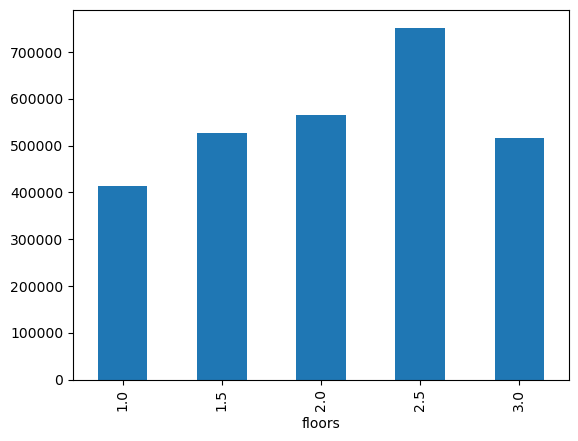

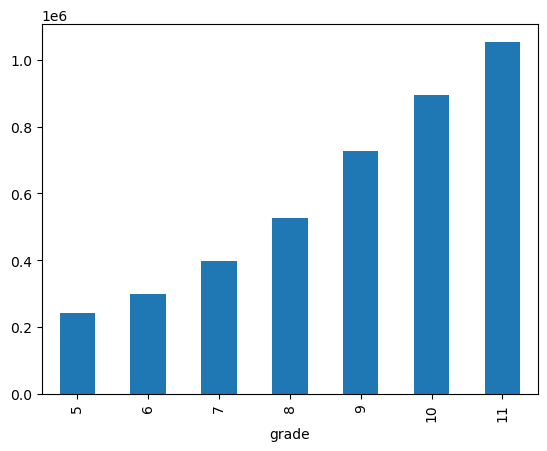

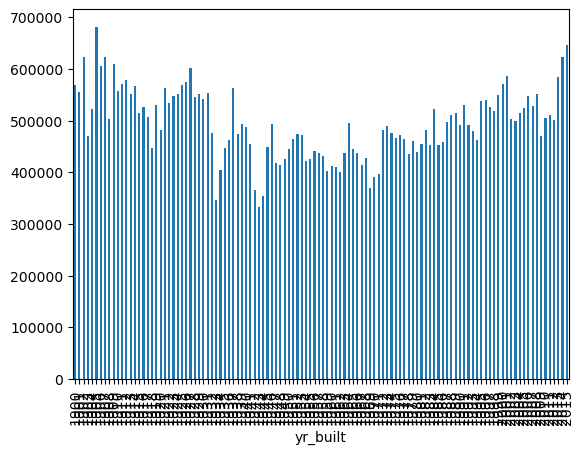

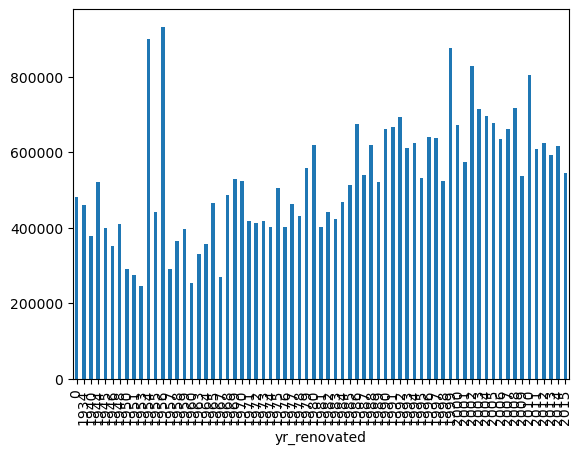

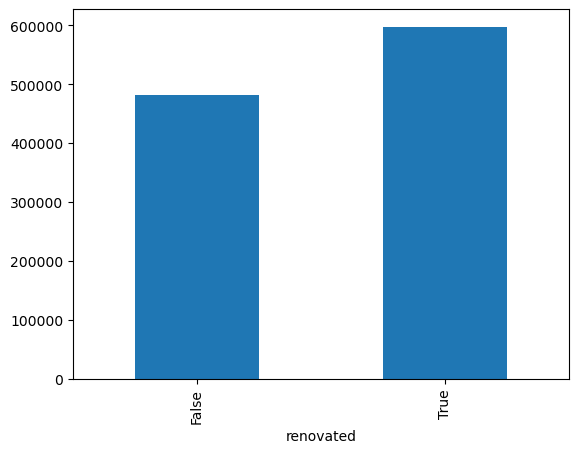

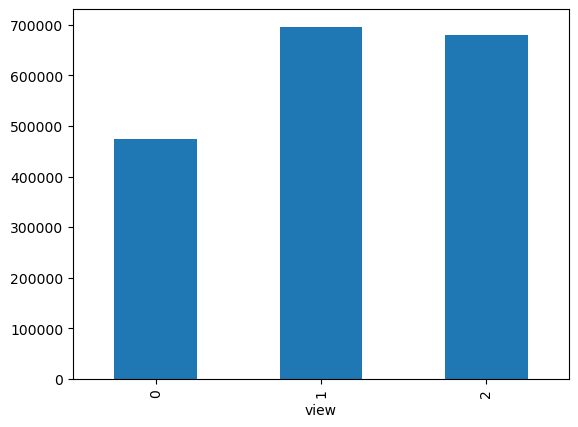

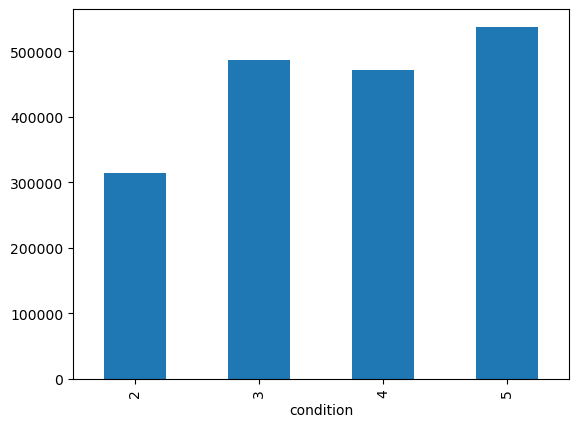

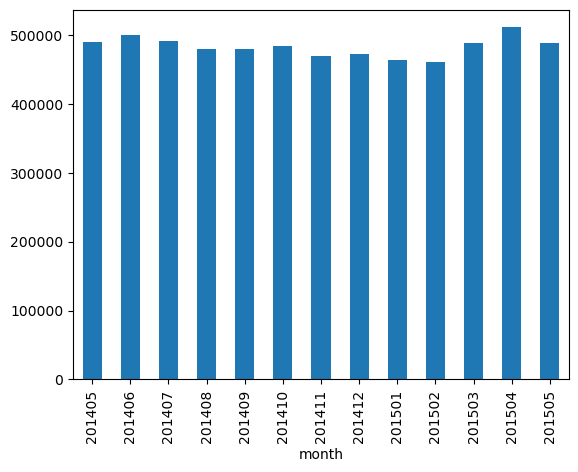

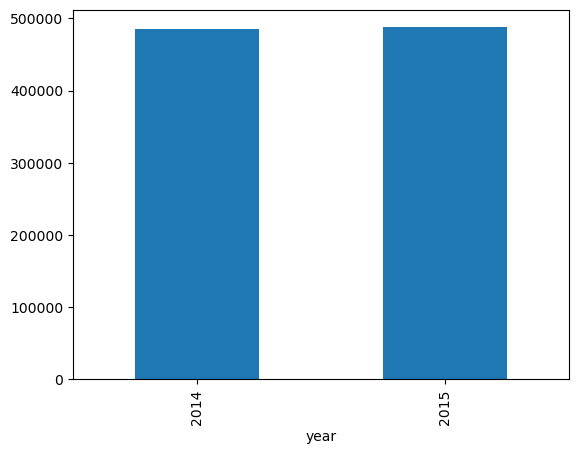

In [17]:
for k in cat:
    df_n.groupby([k])['price'].mean().plot.bar()
    plt.show()

Análise da correlação das variáveis numéricas

In [24]:
num = df_n.drop(columns=['view','condition','month','year']).select_dtypes(include=[float,int])
print(num.columns)

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'waterfront', 'sqft_above', 'sqft_basement', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'center_distance', 'sqft_price',
       'new_state'],
      dtype='object')


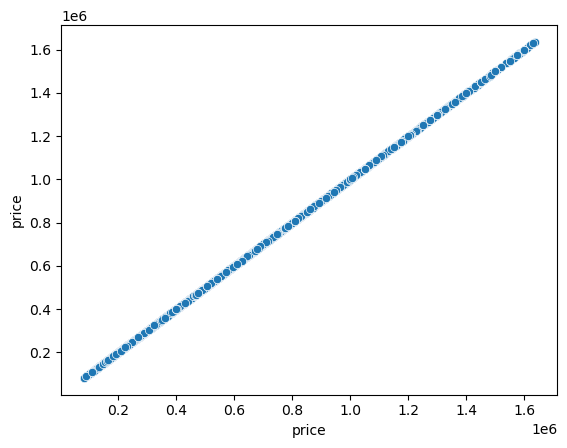

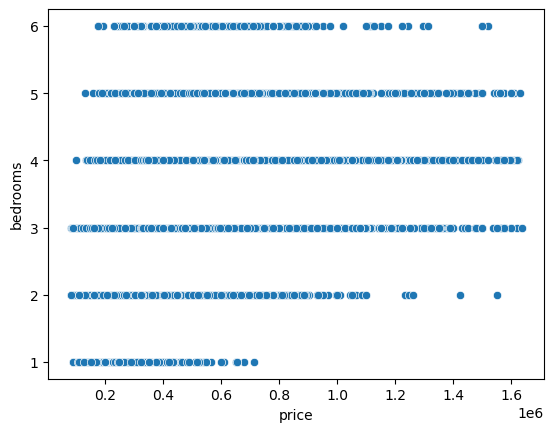

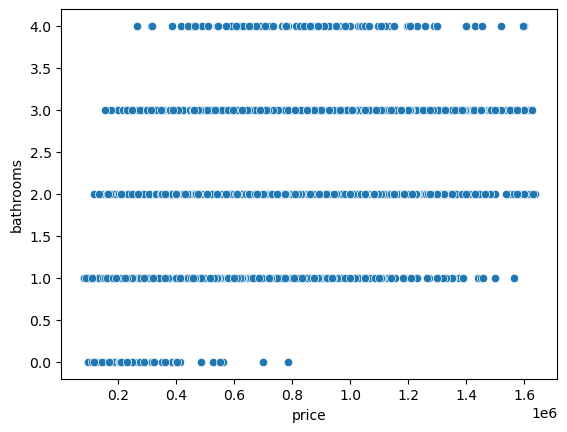

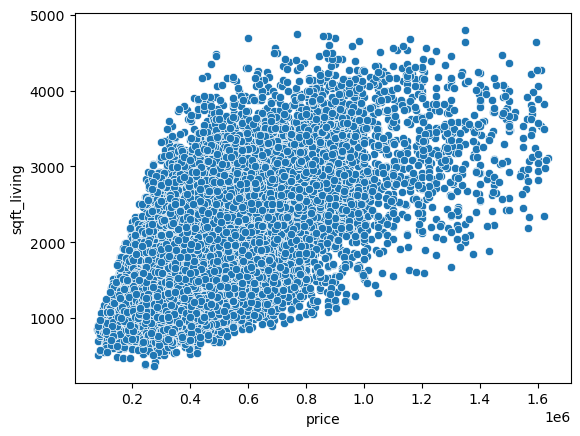

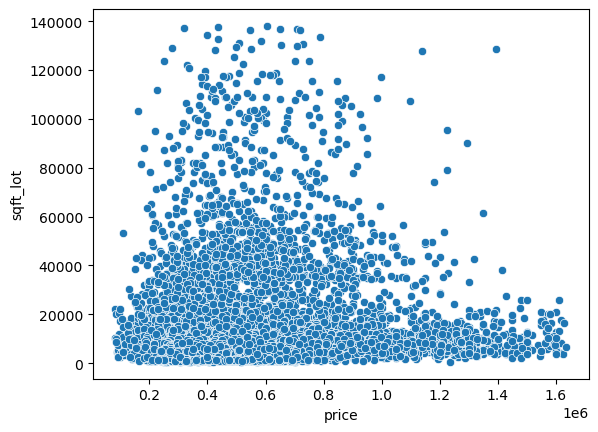

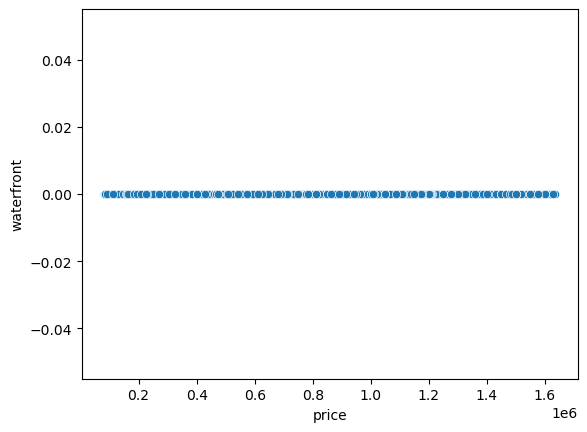

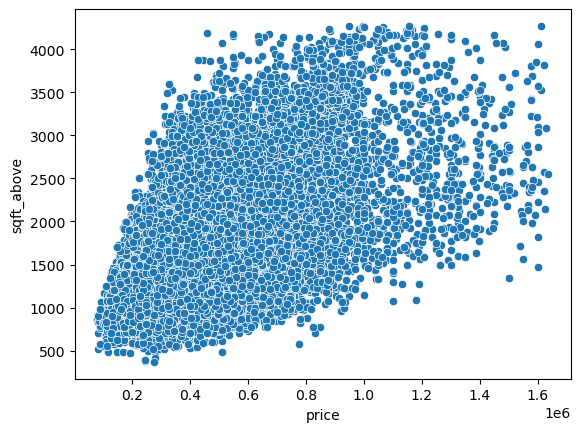

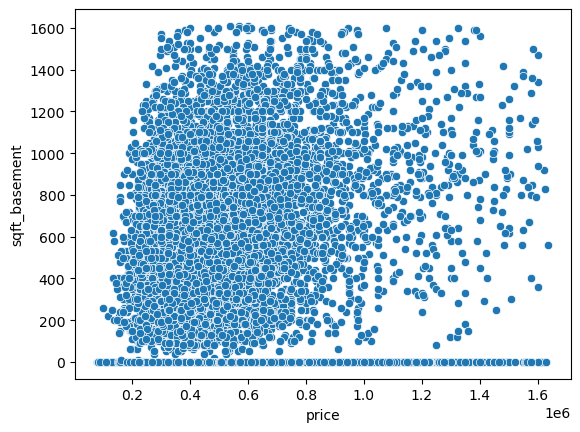

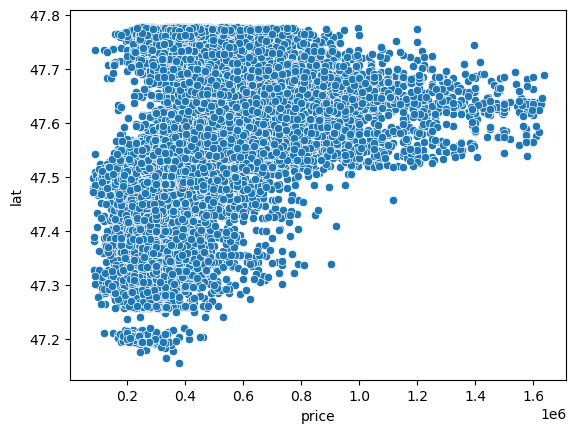

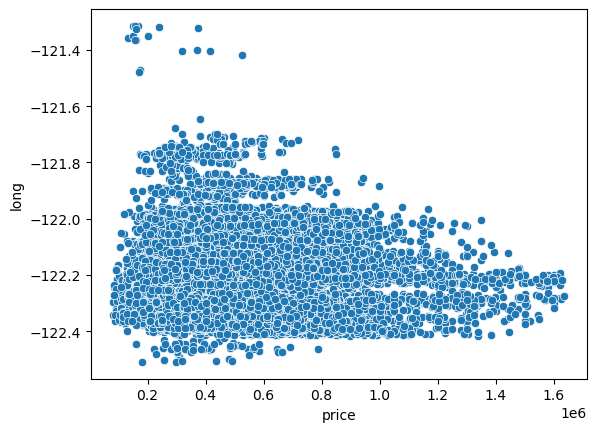

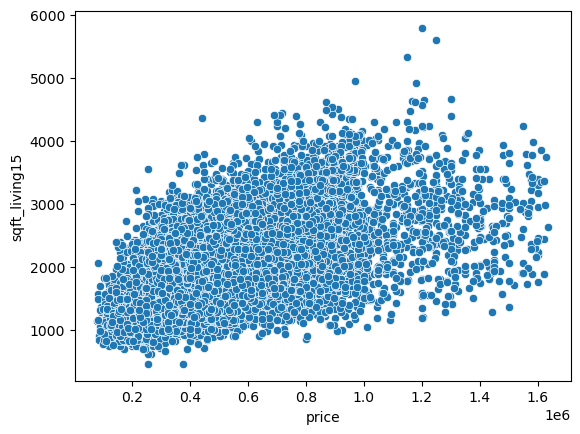

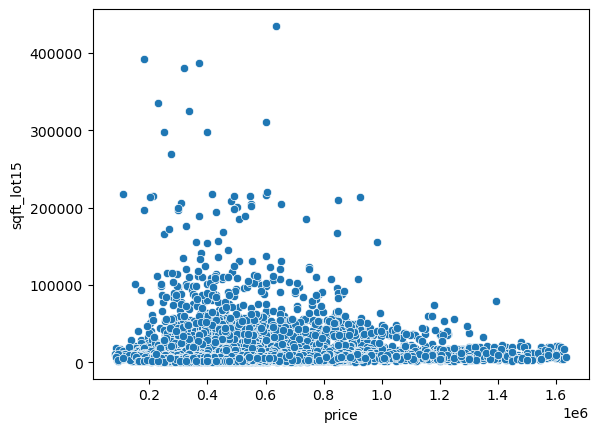

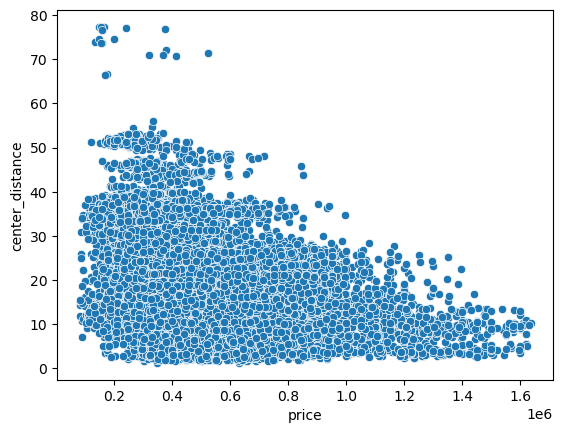

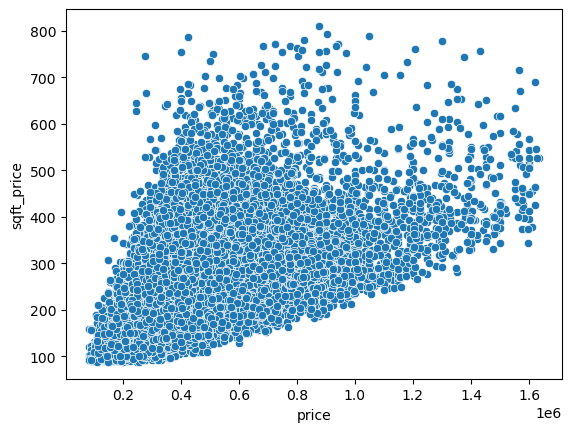

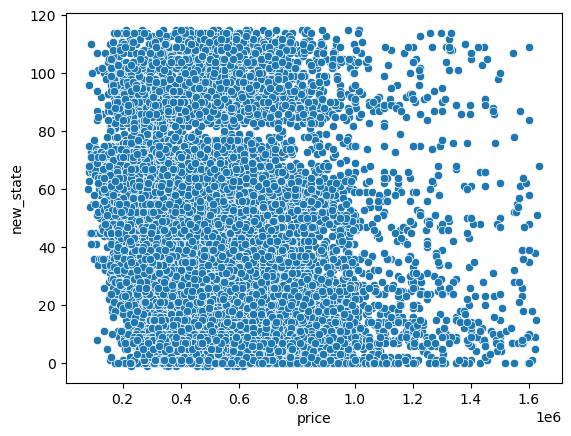

In [19]:
for n in num:
    sns.scatterplot(df_n,x='price',y=n)
    plt.show()

#### Feature Selection

O teste qui-quadrado é uma estatística de teste que avalia a associação entre duas variáveis categóricas. Ele compara as frequências observadas com as frequências esperadas sob a hipótese nula de que as duas variáveis são independentes.

P-values: Indicam a significância estatística da associação. P-values baixos (geralmente menores que 0.05) indicam que a associação é estatisticamente significativa.

No contexto de feature selection usando o p-vaue, um baixo p-value indica que há uma forte evidência desta variável contra a hipótese nula. Ou seja, forte evidência de que haja uma relação com a variável alvo.

In [25]:
from sklearn.feature_selection import chi2 #categorical values

In [26]:
#Feature selection para variáveis categoricas

feature_cat = df_n.drop(num.columns,axis=1)
feature_cat['waterfront'] = df_n['waterfront']

y = df_n['price'].astype(float)

feature_cat.head()

,id,date,floors,view,condition,grade,yr_built,yr_renovated,zipcode,month,year,neighb_id,renovated,waterfront
0,7129300520,20141013,1.0,0,3,7,1955,0,98178,201410,2014,178,False,0
1,6414100192,20141209,2.0,0,3,7,1951,1991,98125,201412,2014,125,True,0
2,5631500400,20150225,1.0,0,3,6,1933,0,98028,201502,2015,028,False,0
3,2487200875,20141209,1.0,0,5,7,1965,0,98136,201412,2014,136,False,0
4,1954400510,20150218,1.0,0,3,8,1987,0,98074,201502,2015,074,False,0


In [27]:
chi = chi2(feature_cat,y)
p_values = pd.Series(chi[1])
p_values.index = feature_cat.columns
p_values

#seleção de waterfront e renovated, únicas variáveis com p-value menor que 0.05

id              0.000000
date            0.851740
floors          1.000000
view            0.000000
condition       1.000000
grade           1.000000
yr_built        1.000000
yr_renovated    0.000000
zipcode         1.000000
month           1.000000
year            1.000000
neighb_id       0.000000
renovated       0.000713
waterfront           NaN
dtype: float64

_Nota-se que waterfront e renovated são variáveis com p-value baixo, logo, prováveis candidatos a terem uma associação com a variável-alvo._

Agora analisaremos as correlações das variáveis numéricas em relação à variável alvo: price.

<Axes: >

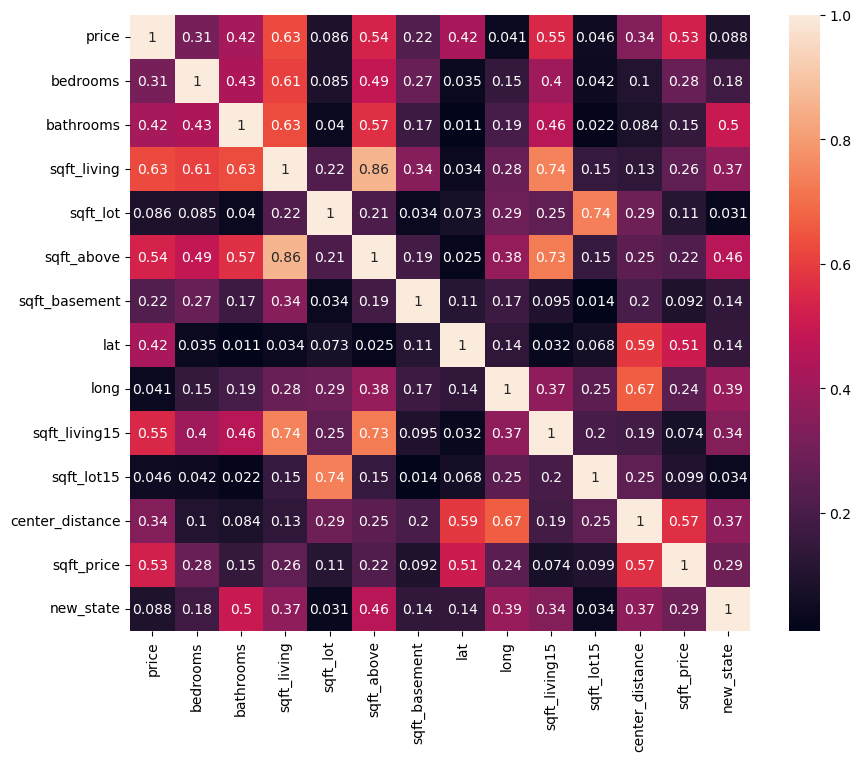

In [28]:
plt.figure(figsize=(10, 8))
feature_num = abs(df_n[num.columns].drop(columns=['waterfront']).corr())
sns.heatmap(feature_num,annot=True)

#seleção de sqft_living, sqft_above,sqft_living15

### Desenvolvimento do modelo de predição de preços

In [29]:
#importando dependências sklearn

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

Primeiramente avaliaremos a performance do modelo para todo o dataset.

_Se necessário, utilizaremos o resultado do feature selection para otimizar o modelo._

In [30]:

# data = df_n[['price','sqft_above','sqft_living','waterfront','bathrooms','waterfront','renovated']]
data = df_n.copy()
data['renovated'] = data['renovated'].astype(int)

X = data.drop(columns=['price'])
y = data['price'].astype(int)

# Escalonar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=24)

_Divisão dos dados em treinamento e teste_

In [31]:
X_test.size/(X_train.size+X_test.size)

0.20001009642081882

In [32]:
y_test.size/(y_train.size+y_test.size)

0.20001009642081882

_Criação de lista de modelos para seleção do mais performático_

In [33]:
models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

_Avaliar o modelo_

In [34]:
for model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Mean RMSE: {rmse_scores.mean():.4f}, Std Dev: {rmse_scores.std():.4f}")
    print("-" * 40)

Model: LinearRegression
Mean RMSE: 69807.9279, Std Dev: 1340.0432
----------------------------------------
Model: Ridge
Mean RMSE: 69708.0818, Std Dev: 1439.2630
----------------------------------------
Model: Lasso
Mean RMSE: 69708.6187, Std Dev: 1437.8221
----------------------------------------
Model: DecisionTreeRegressor
Mean RMSE: 24286.8402, Std Dev: 599.3996
----------------------------------------
Model: RandomForestRegressor
Mean RMSE: 13639.4110, Std Dev: 1285.5125
----------------------------------------
Model: GradientBoostingRegressor
Mean RMSE: 16622.2648, Std Dev: 762.6430
----------------------------------------


Random Forest foi o modelo mais performático para este conjunto de dados, já possuindo uma performance satisfatória.

Não será necessário utilizar as variáveis do feature selection.

In [35]:
#random forest is the best model

best_model = RandomForestRegressor(n_estimators=200, max_features='auto', max_depth=None,
                                    min_samples_split=2, min_samples_leaf=1, random_state=42)

# Fit the best model
best_model.fit(X_train, y_train)

RandomForestRegressor(max_features='auto', n_estimators=200, random_state=42)

In [36]:
y_pred = best_model.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Regression Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

Random Forest Regression Performance:
RMSE: 10821.4082
R-squared: 0.9979


O modelo atingiu R2 de 99%.

As variáveis mais significativas para a performance do modelo foram: grade, sqft_price, sqft_living.

Conforme consta abaixo.

In [37]:
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': list(data.drop(columns={'price'}).columns), 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

            Feature  Importance
10            grade    0.303280
24       sqft_price    0.288089
4       sqft_living    0.239415
16              lat    0.164849
11       sqft_above    0.001116
18    sqft_living15    0.000433
5          sqft_lot    0.000272
0                id    0.000272
17             long    0.000250
12    sqft_basement    0.000241
22  center_distance    0.000236
25        new_state    0.000234
13         yr_built    0.000217
1              date    0.000215
19       sqft_lot15    0.000210
20            month    0.000120
15          zipcode    0.000109
23        neighb_id    0.000108
2          bedrooms    0.000074
9         condition    0.000070
6            floors    0.000054
8              view    0.000047
3         bathrooms    0.000045
21             year    0.000023
14     yr_renovated    0.000012
26        renovated    0.000010
7        waterfront    0.000000


### Testando a predição com novos dados

Abaixo, geraremos um dataframe fictício para prever.

In [38]:
colunas = list(data.drop(columns={'price'}).columns)

trial = [
    ['001', '20240617', 3, 2, 1800.0, 5000.0, '1.0', 0, 0, 3, '7', 1500.0, 300.0, '1990', '2005', '98001', 47.5112, -122.257, 1720.0, 4000.0, 6, 2024, 5.0, '01', 300.0, 1, False],
    ['002', '20240617', 4, 3, 2500.0, 6000.0, '2.0', 0, 1, 4, '8', 2000.0, 500.0, '2000', '2010', '98002', 47.7210, -122.319, 2400.0, 5000.0, 6, 2024, 10.0, '02', 350.0, 1, True],
    ['003', '20240617', 2, 1, 1400.0, 4000.0, '1.5', 1, 0, 3, '6', 1200.0, 200.0, '1985', '0', '98003', 47.3899, -122.250, 1350.0, 3800.0, 6, 2024, 15.0, '03', 250.0, 0, False],
    ['004', '20240617', 5, 4, 3000.0, 7000.0, '2.5', 0, 2, 5, '9', 2500.0, 500.0, '2010', '2020', '98004', 47.7379, -122.312, 2900.0, 6800.0, 6, 2024, 8.0, '04', 400.0, 1, True],
    ['005', '20240617', 3, 2, 2000.0, 4500.0, '2.0', 0, 0, 4, '7', 1600.0, 400.0, '1995', '0', '98005', 47.6156, -122.347, 1950.0, 4400.0, 6, 2024, 12.0, '05', 320.0, 0, False]
]

df_trial = pd.DataFrame(trial, columns=colunas)

In [39]:
print(len(data.drop(columns=['price']).columns))
print(len(df_trial.columns))

27
27


In [40]:
predict_price = best_model.predict(df_trial)
df_resulted = df_trial.copy()
df_resulted['price'] = predict_price 
df_resulted

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year,center_distance,neighb_id,sqft_price,new_state,renovated,price
0,001,20240617,3,2,1800.0,5000.0,1.0,0,0,3,7,1500.0,300.0,1990,2005,98001,47.5112,-122.257,1720.0,4000.0,6,2024,5.0,01,300.0,1,False,1550596.45
1,002,20240617,4,3,2500.0,6000.0,2.0,0,1,4,8,2000.0,500.0,2000,2010,98002,47.7210,-122.319,2400.0,5000.0,6,2024,10.0,02,350.0,1,True,1548657.45
2,003,20240617,2,1,1400.0,4000.0,1.5,1,0,3,6,1200.0,200.0,1985,0,98003,47.3899,-122.250,1350.0,3800.0,6,2024,15.0,03,250.0,0,False,1549203.95
3,004,20240617,5,4,3000.0,7000.0,2.5,0,2,5,9,2500.0,500.0,2010,2020,98004,47.7379,-122.312,2900.0,6800.0,6,2024,8.0,04,400.0,1,True,1548657.45
4,005,20240617,3,2,2000.0,4500.0,2.0,0,0,4,7,1600.0,400.0,1995,0,98005,47.6156,-122.347,1950.0,4400.0,6,2024,12.0,05,320.0,0,False,1547887.45
